In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [2]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
#data = xr.open_dataset('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_kernel_updated.zarr')
#data = xr.open_dataset('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_updated_UV_fieldset.zarr')
data = xr.open_dataset('/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_kernels_tau_0_01_ratio_0_1_sv_5_AD_0_052.zarr')

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [3]:
data_sewage_water = data.where(data.status == 1)
data_colloidal_water = data.where(data.status == 2)
data_marine_water = data.where(data.status == 3)
data_sewage_sediment = data.where(data.status == 11)
data_colloidal_sediment = data.where(data.status == 12)
data_marine_sediment = data.where(data.status == 13)

In [4]:
data_sewage_water.obs.values

array([   0,    1,    2, ..., 1457, 1458, 1459], dtype=int32)

/tmp/ipykernel_347292/1142909267.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)


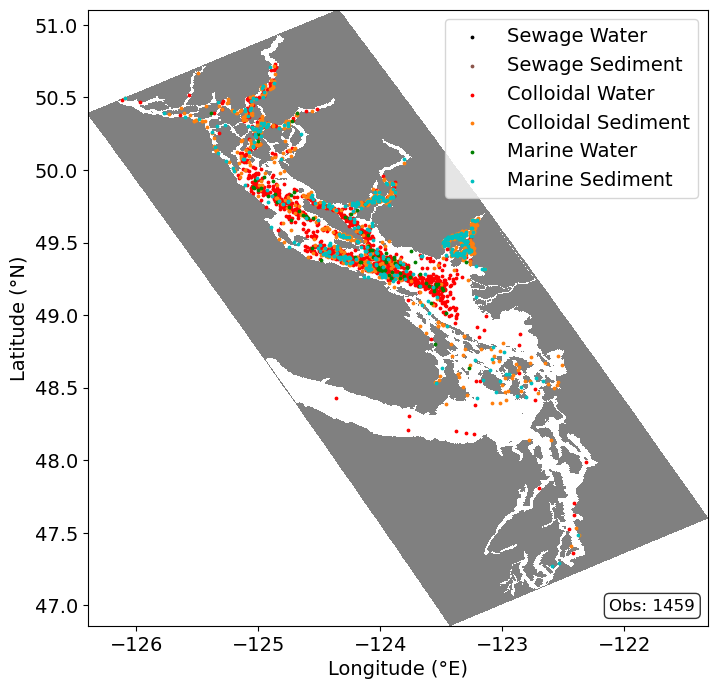

In [5]:
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

# Load mask
mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')

# Static color map for land (gray) and water (transparent)
colors = [(0.5, 0.5, 0.5, 1),  # Gray for land (1)
          (0, 0, 0, 0)]        # Transparent for water (0)
cmap = ListedColormap(colors)

# === Set up figure ===
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Draw background land mask
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap=cmap)

# Initialize scatter plots with s=3
sc_sewage_water = ax.scatter([], [], c='k', s=3, label='Sewage Water')
sc_sewage_sed = ax.scatter([], [], c='tab:brown', s=3, label='Sewage Sediment')
sc_coll_water = ax.scatter([], [], c='r', s=3, label='Colloidal Water')
sc_coll_sed = ax.scatter([], [], c='tab:orange', s=3, label='Colloidal Sediment')
sc_mar_water = ax.scatter([], [], c='g', s=3, label='Marine Water')
sc_mar_sed = ax.scatter([], [], c='c', s=3, label='Marine Sediment')

# Time text box (now for obs step)
time_text = ax.text(0.98, 0.02, '', transform=ax.transAxes,
                    ha='right', va='bottom', fontsize=12,
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Axis setup
ax.set_ylabel('Latitude (°N)')
ax.set_xlabel('Longitude (°E)')
ax.set_xlim(mask['nav_lon'].min(), mask['nav_lon'].max())
ax.set_ylim(mask['nav_lat'].min(), mask['nav_lat'].max())
ax.legend(loc='upper right')

# === Animation function ===
def update(frame):
    # Update scatter data for this time step
    sc_sewage_water.set_offsets(np.column_stack((data_sewage_water.lon[:, frame], data_sewage_water.lat[:, frame])))
    sc_sewage_sed.set_offsets(np.column_stack((data_sewage_sediment.lon[:, frame], data_sewage_sediment.lat[:, frame])))
    sc_coll_water.set_offsets(np.column_stack((data_colloidal_water.lon[:, frame], data_colloidal_water.lat[:, frame])))
    sc_coll_sed.set_offsets(np.column_stack((data_colloidal_sediment.lon[:, frame], data_colloidal_sediment.lat[:, frame])))
    sc_mar_water.set_offsets(np.column_stack((data_marine_water.lon[:, frame], data_marine_water.lat[:, frame])))
    sc_mar_sed.set_offsets(np.column_stack((data_marine_sediment.lon[:, frame], data_marine_sediment.lat[:, frame])))

    # Set obs step text
    time_text.set_text(f"Obs: {frame}")

    return (sc_sewage_water, sc_sewage_sed, sc_coll_water,
            sc_coll_sed, sc_mar_water, sc_mar_sed, time_text)

# Total frames (time steps)
n_frames = data_sewage_water.sizes['obs']

# Create animation — KEEP ALL FRAMES
ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=20, blit=True)

# Save 10x faster by increasing FPS
ani.save('Particles_animation_365_days_full_kernels_tau_0_01_ratio_0_1_sv_5_AD_0_052.mp4', dpi=150, fps=100)

